# Words triggering a transformation

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'include'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_pilot_8c


Imports for the analysis

In [3]:
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Triggering for categorical variables

### 2.1 Setup

We need a few helper functions first

In [4]:
def additional_features(parent, child):
    return {
        'oc_rate': np.nan if child is None else parent.oc_distance(child),
        'oc_transmitted': np.nan if child is None else int(parent.oc_distance(child) == 0),
        'token_length': len(parent.tokens),
        'content_length': len(parent.content_tokens),
    }

def base(parent, child):
    return {
        # indices
        'tree_id': parent.tree.id,
        'parent_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
        'root_memorable': int(parent.tree.id % 2 == 0),
    }

def final_feature_name(feature, rel):
    return feature + (('-rel' + rel) if rel is not None else '')

def rows(parent, child, feature, rel=None):
    parent_words = (parent.words if STOPWORDS == Sentence._SW_INCLUDE
                    else (parent.content_ids, parent.content_lemmas))
    child_words = (child.words if STOPWORDS == Sentence._SW_INCLUDE
                   else (child.content_ids, child.content_lemmas))
    # Get the first difference between parent and child
    diff_words = np.where([w1 != w2 for (w1, w2) in zip(parent_words, child_words)])[0]
    if len(diff_words) == 0:
        # No difference, so skip this parent->child couple
        return
    divergence = diff_words[0]
    
    parent_values = parent.features(feature, stopwords=STOPWORDS, rel=rel)[:divergence + 1]
    child_values = child.features(feature, stopwords=STOPWORDS, rel=rel)[:divergence + 1]
    if np.isnan(parent_values[-1]):
        # The divergent word is not coded for this feature, so skip this
        return
    for i, (parent_value, child_value) in enumerate(zip(parent_values, child_values)):
        parent_start_quantile, parent_stop_quantile = quantile_interval(parent_values, parent_value)
        row = base(parent, child)
        row.update(additional_features(parent, child))
        row.update({
            'feature': final_feature_name(feature, rel),
            'parent_value': parent_value,
            'child_value': child_value,
            'is_divergence': i == divergence,
            'sentence_position': i / (len(parent_words) - 1),
            'parent_start_quantile': parent_start_quantile,
            'parent_stop_quantile': parent_stop_quantile,
        })
        yield row

Now build the master DataFrame that we plot below

In [5]:
data = []
for tree in Tree.objects.experiment:
    for parent in tree.sentences.kept:

        if parent.depth >= config.target_branch_depth:
            # Ignore reformulations with out-of-shape children
            continue
        
        children = parent.children.kept
        if len(children) == 0:
            # Ignore leaves, we already saw them
            # with their parent
            continue
        
        for child in children:
            for feature in Sentence.WORD_FEATURES.keys():
                for row in rows(parent, child, feature, rel=None):
                    data.append(row)
                for row in rows(parent, child, feature, rel='mean'):
                    data.append(row)
            for feature in Sentence.CATEGORICAL_WORD_FEATURES:
                for row in rows(parent, child, feature, rel=None):
                    data.append(row)
                # No sentence-relative features for categorical features

data = pd.DataFrame(data)

features = sorted(set(data.feature))
continuous_features = sorted(Sentence.WORD_FEATURES.keys())
continuous_rel_features = list(map(lambda f: final_feature_name(f, 'mean'), continuous_features))
index = sorted(set(data.columns).difference(['value', 'feature']))

Each sentence counts for one in the plots below, so we have to weigh each recorded word accordingly

In [6]:
# Weight is 1, at first
data['weight'] = 1 * np.isfinite(data.parent_value)

# Divided by the number of words counted in the parent before (and including) divergence
print('Computing word weights for all appearances')
data['weight'] = data\
    .groupby(['parent_id', 'child_id', 'feature'])['weight']\
    .transform(lambda x: x / data.loc[x.index]['weight'].sum())

Computing word weights for all appearances


And the actual plotting function

In [7]:
def plot_categorical_susties(data, axes=None, rename_index=None, count_plot_kws={},
                             suscept_plot_kws={}, ci_kws={}):
    if axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    feature = data.feature.iloc[0]
    texfeature = feature.replace('_', ' ')
    ci_lw = ci_kws.pop('lw', 4)
    ci_color = ci_kws.pop('color', 'grey')

    # Compute suscept values
    susties = data\
        .groupby('parent_value')['is_divergence']\
        .aggregate({'susceptibility': lambda x: x.sum() / data.loc[x.index, 'weight'].sum(),
                    'n_diverged': lambda x: x.sum(),
                    'n_preceded': lambda x: data.loc[x.index, 'weight'].sum()})\
        .rename_axis(feature)
    if rename_index is not None:
        susties = susties.rename(index=rename_index)
    
    # Plot counts
    susties[['n_diverged', 'n_preceded']]\
        .rename(columns={'n_diverged': r'$s_{{{}}}$'.format(texfeature),
                         'n_preceded': r'$s_{{{}}}^0$'.format(texfeature)})\
        .plot(ax=axes[0], kind='bar', **count_plot_kws)
    # With their CIs
    total_diverged = susties.n_diverged.sum()
    cis = multinomial_proportions_confint(susties.n_diverged.round(),
                                          method='goodman')
    for i in range(len(susties)):
        axes[0].plot([i-.125, i-.125], cis[i] * total_diverged,
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None,
                     **ci_kws)
    # Set chrome
    axes[0].legend()
    axes[0].set_ylabel('Counts')
    
    # Plot susceptibilities
    susties['susceptibility']\
        .rename(r'$\sigma_{{{}}}$'.format(texfeature))\
        .apply(np.log10)\
        .plot(ax=axes[1], kind='bar', legend=True, **suscept_plot_kws)
    axes[1].set_ylabel('Susceptibility')
    # With their CIs
    for i in range(len(susties)):
        axes[1].plot([i, i],
                     np.log10(cis[i] * total_diverged / susties.n_preceded.iloc[i]),
                     lw=ci_lw, color=ci_color,
                     label='95% CI' if i == 0 else None,
                     **ci_kws)
    axes[1].plot([-1, len(susties)], [0, 0], '--',
                 color=sb.desaturate(sb.color_palette()[0], 0.2),
                 label=r'$\mathcal{H}_0$')
    # Set chrome
    axes[1].legend(loc='best')
    axes[1].set_yticklabels(['$10^{{{:.2}}}$'.format(tick)
                             for tick in axes[1].get_yticks()])
    
    return axes

### 2.2 POS Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10



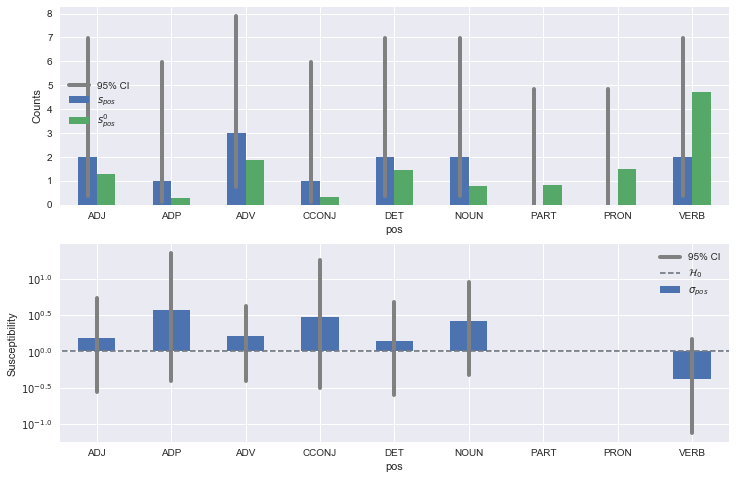

In [8]:
axes = plot_categorical_susties(data=data[data.feature == 'pos'],
                                rename_index=lambda n: nlp.vocab.strings[int(n)],
                                count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})

### 2.3 "Dependency relation" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fed0af24a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fed0ad86160>], dtype=object)

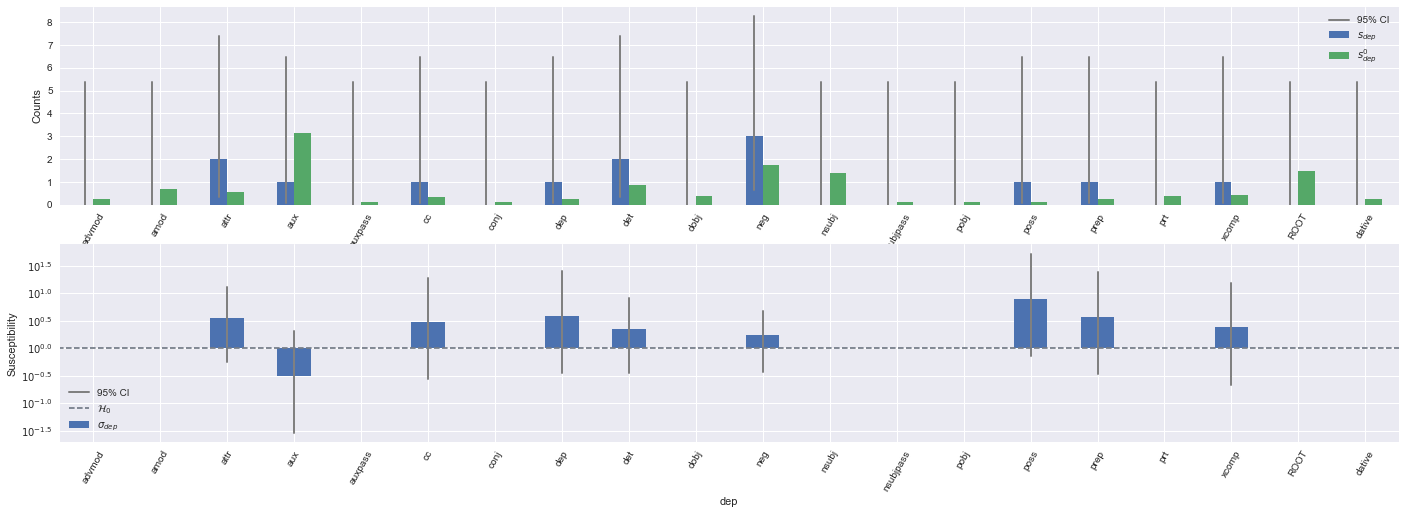

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
plot_categorical_susties(data=data[data.feature == 'dep'], axes=axes,
                         rename_index=lambda n: nlp.vocab.strings[int(n)],
                         count_plot_kws={'rot': 60}, suscept_plot_kws={'rot': 60},
                         ci_kws={'lw': 2})

### 2.4 "Depth of dependency tree below token" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10



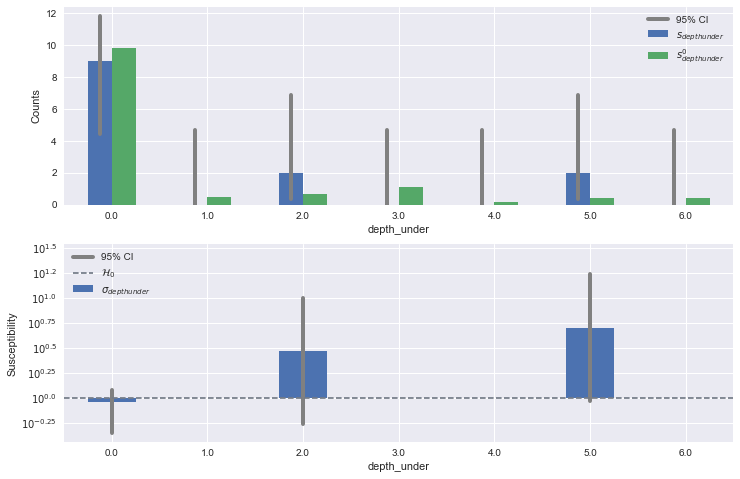

In [10]:
axes = plot_categorical_susties(data=data[data.feature == 'depth_under'],
                                count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})

### 2.5 "Depth of dependency tree above token" Susceptibility for appearances, disappearances, compared to parent sentence

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10



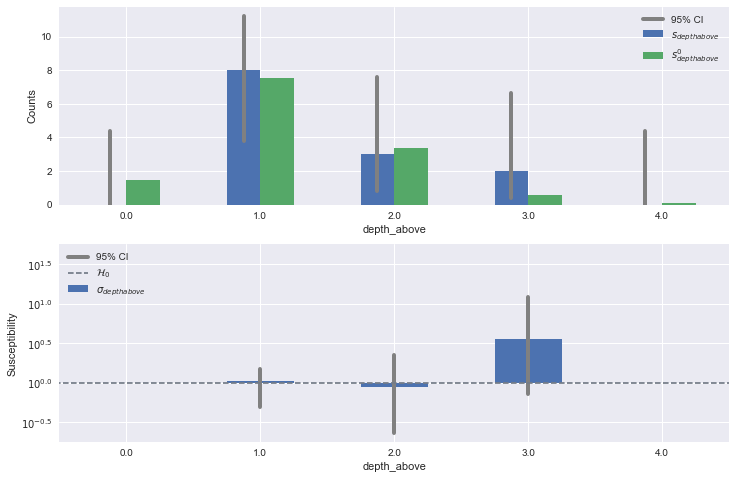

In [11]:
axes = plot_categorical_susties(data=data[data.feature == 'depth_above'],
                                count_plot_kws={'rot': 0}, suscept_plot_kws={'rot': 0})

### 2.6 Sentence position

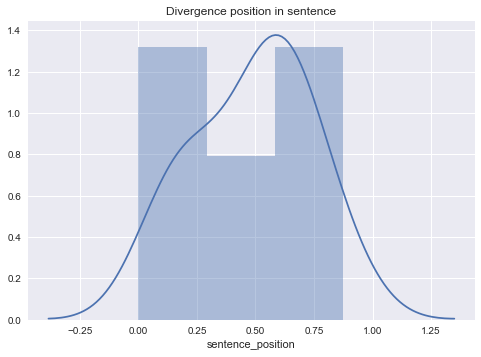

In [12]:
ax = plt.gca()
sb.distplot(data[(data.feature == 'pos') & data.is_divergence].sentence_position,
            ax=ax, kde_kws={'clip': (0, 1)})
ax.set_title('Divergence position in sentence')

## 3 Triggering for continuous variables

### 3.1 Setup

Our plotting function

In [13]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    quantiles = kwargs.get('quantiles', False)
    value = data.parent_value
    binning = kwargs.get('binning', 5)
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(binning, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[value_bins == i].is_divergence.sum()
        h0s[i] = data[value_bins == i].weight.sum()
    total = sum(heights)
    # Set any null values of heigths to .5 for confints
    cis = (multinomial_proportions_confint([h or .5 for h in heights.round()],
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{\phi}'
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.yscale('log')

A helper to plot features in a grid

In [14]:
def plot_grid(data, features, plot_function, xlabel, ylabel,
              sharex=False, sharey=True, plot_kws={}):
    g = sb.FacetGrid(data=data, dropna=False,
                     sharex=sharex, sharey=sharey,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=6, aspect=1.2, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
    return g

### 3.2 Features binned by global word distribution in the dataset

#### 3.2.1 Binning by fixed width

##### 3.2.1.1 Absolute values

In [15]:
def set_ylims(g, lims):
    lower, upper = lims
    preticks = [lower, 1, upper]
    powers = [int(np.floor(np.log10(tick))) for tick in preticks]
    ticks = [np.sign(p+.1) * np.floor(np.sign(p+.1) * tick * 10**(-p)) * 10**p
             for tick, p in zip(preticks, powers)]
    g.set(ylim=lims, yticks=ticks)
    g.set_yticklabels([r'${v} \times 10^{{{p}}}$'.format(v=int(t * 10**(-p)), p=p)
                       for t, p in zip(ticks, powers)])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide



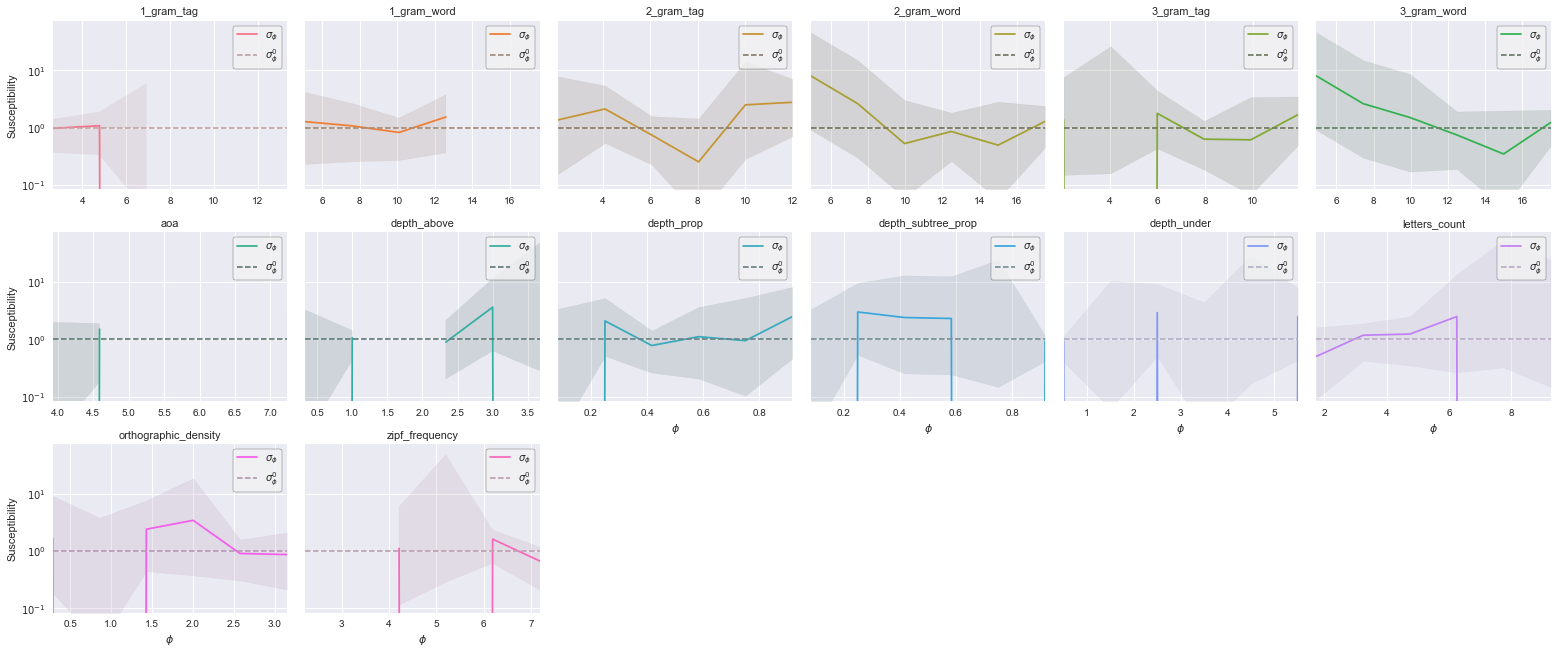

In [16]:
g = plot_grid(data, continuous_features,
              plot_bin_susties,
              r'$\phi$', 'Susceptibility',
              plot_kws={'quantiles': False, 'binning': 6})
#set_ylims(g, (.2, 5))

##### 3.2.1.2 Sentence-relative values

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide



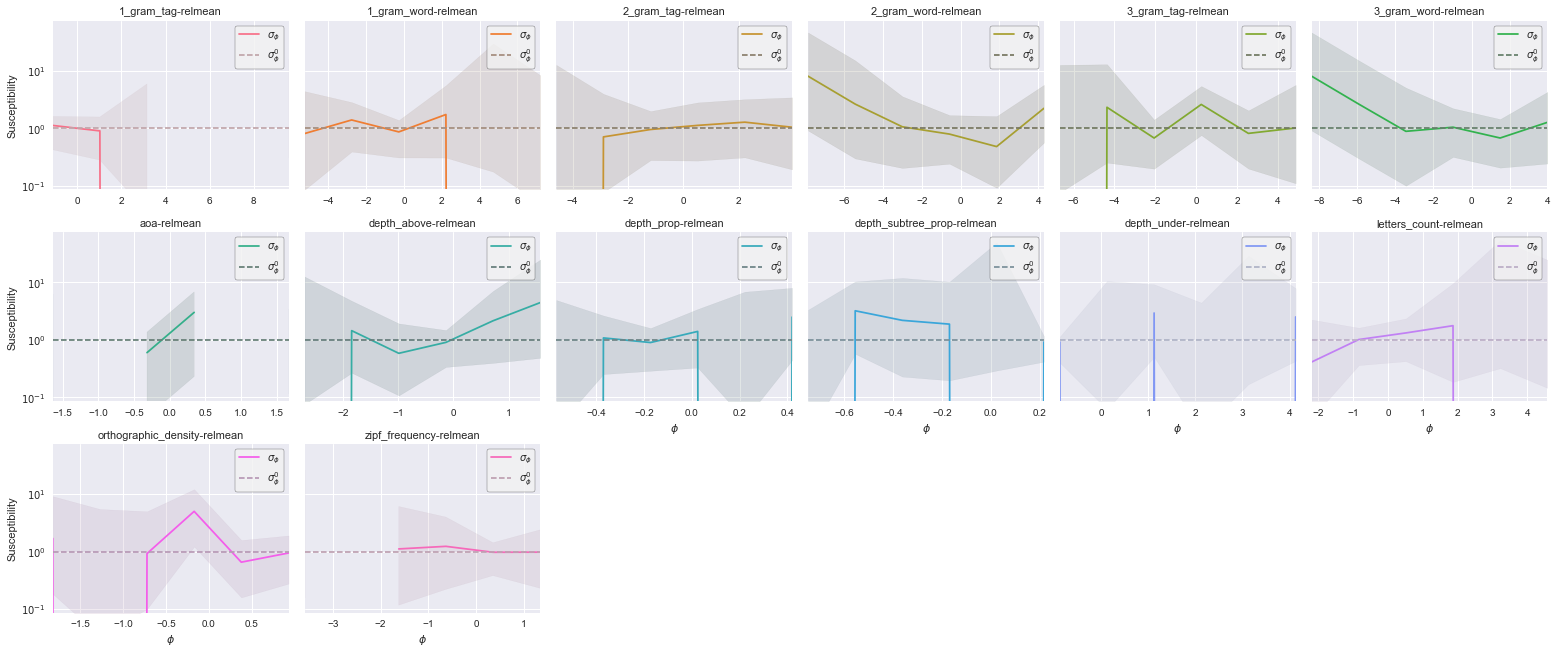

In [17]:
g = plot_grid(data, continuous_rel_features,
              plot_bin_susties,
              r'$\phi$', 'Susceptibility',
              plot_kws={'quantiles': False, 'binning': 6})
#set_ylims(g, (.2, 5))

#### 3.2.2 Binning by quantiles

##### 3.2.2.1 Absolute values

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.5, right=0.5
  'left=%s, right=%s') % (left, right))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=3.0, right=3.0
  'left=%s, right=%s') % (left, right))



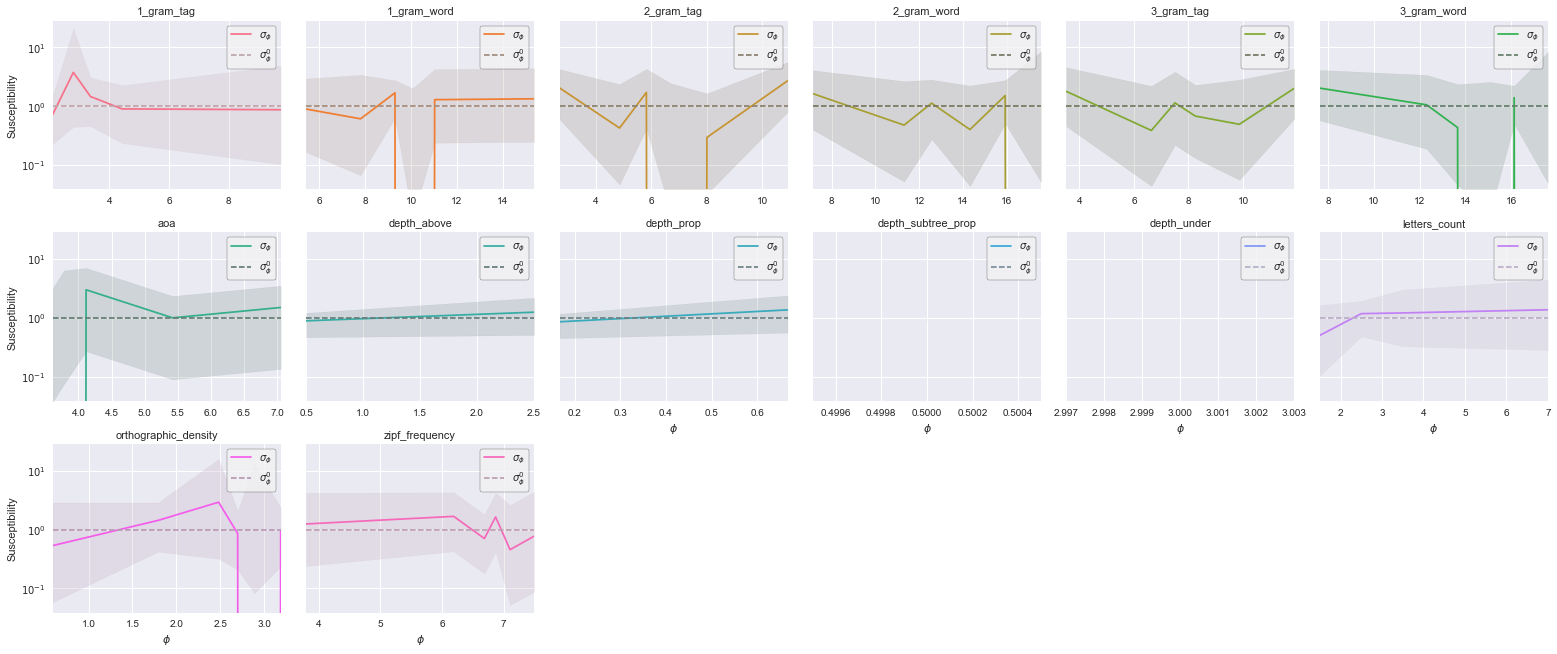

In [18]:
g = plot_grid(data, continuous_features,
              plot_bin_susties,
              r'$\phi$', 'Susceptibility',
              plot_kws={'quantiles': True, 'binning': 6})
#set_ylims(g, (.2, 5))

##### 3.2.2.2 Sentence-relative values

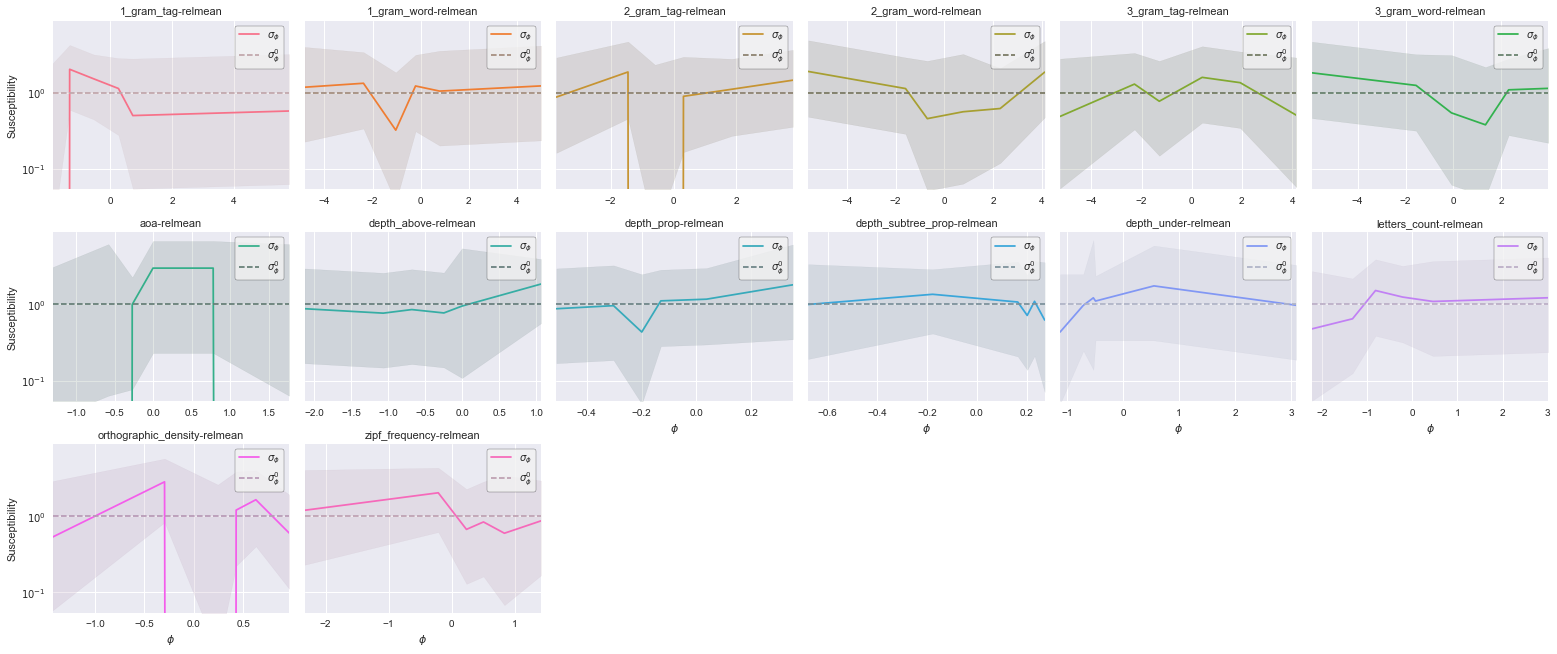

In [19]:
g = plot_grid(data, continuous_rel_features,
              plot_bin_susties,
              r'$\phi$', 'Susceptibility',
              plot_kws={'quantiles': True, 'binning': 6})
#set_ylims(g, (.2, 5))

### 3.3 Features placed in the in-sentence word distributions

#### 3.3.1 Setup

Our plotting function

In [20]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    bin_count = kwargs.get('binning', 5)
    
    # Compute bin counts
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    step = 1 / bin_count
    for i in range(bin_count):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.parent_stop_quantile)
                          - bound(limits, data.parent_start_quantile))
                         / (data.parent_stop_quantile - data.parent_start_quantile))
        heights[i] = contributions[data.is_divergence].sum()
        h0s[i] = (contributions * data.weight).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, bin_count + 1)
    plt.plot(x, heights / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(h0s), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.yscale('log')

#### 3.3.2 Features placed in the in-sentence word distributions

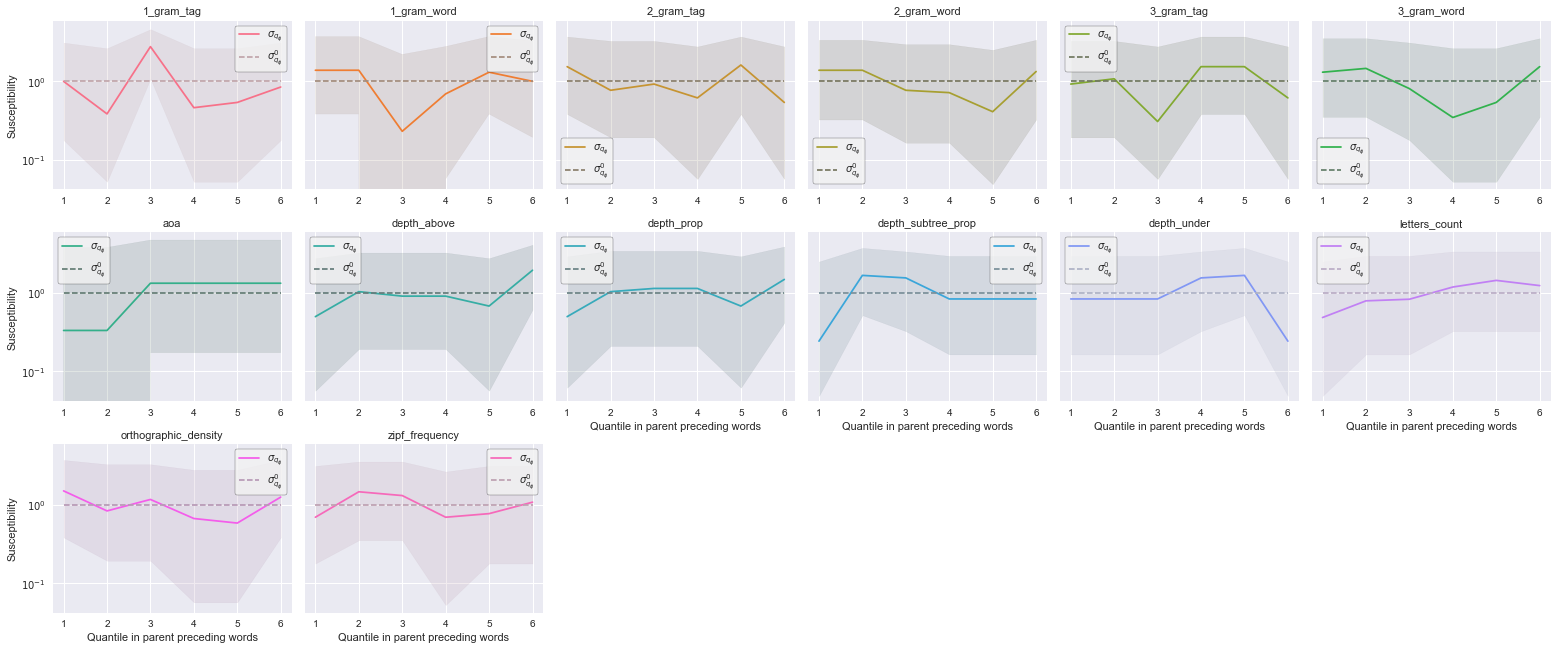

In [21]:
plot_grid(data, continuous_features, plot_sentencequantile_susties,
          'Quantile in parent preceding words', 'Susceptibility',
          plot_kws={'binning': 6})

### Note about bias with depth-related features

`depth_above` and all other depth-related features are not distributed evenly in the sentences: they correlate to the position in the sentence (see graphs below). So our plots above are biased, because obviously the divergent word will be at an extreme value (for those depth-related features) compared to all the words preceding it). To deal with that we should correct, basically by regressing the `feature~position` relationship and transforming those features so they become position-independent.

The only question is: **should we use the regression on the whole dataset (as see below), or the each time a regression on the sentence considered (easier but might fail or behave badly on short sentences)?**

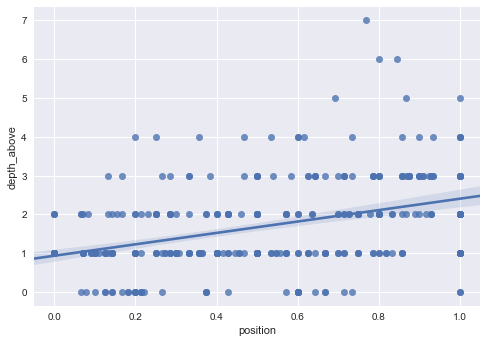

In [22]:
bdata = []
fname = 'depth_above'
for sentence in Sentence.objects.experiment.kept:
    values = sentence.features(fname)
    for i, value in enumerate(values):
        bdata.append({'sentence_id': sentence.id, 'position': i / (len(values) - 1), fname: value})
bdata = pd.DataFrame(bdata)

sb.regplot('position', fname, data=bdata)

And the slope of the regression above, per sentence, plotted against the sentence length:

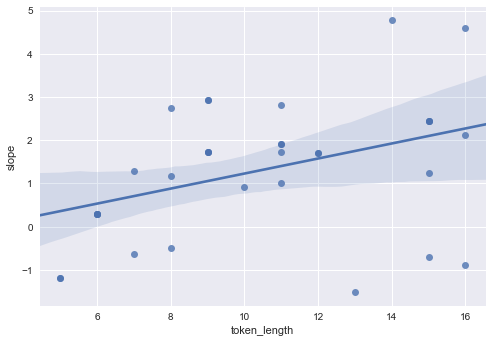

In [23]:
from scipy.stats import linregress
bdata = []
fname = 'depth_above'
for sentence in Sentence.objects.experiment.kept:
    values = sentence.features(fname)
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(values)) / (len(values) - 1), values)
    bdata.append({'sentence_id': sentence.id, 'slope': slope, 'token_length': len(values)})
bdata = pd.DataFrame(bdata)

sb.regplot('token_length', 'slope', data=bdata)

The same two plots for `depth_%`.

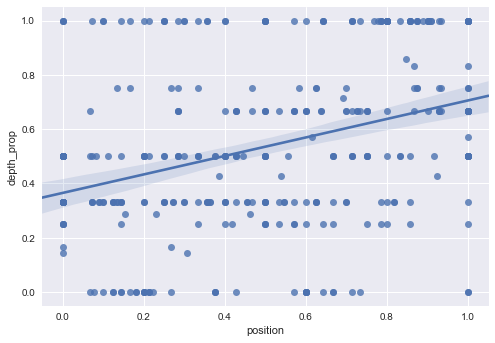

In [24]:
bdata = []
fname = 'depth_prop'
for sentence in Sentence.objects.experiment.kept:
    values = sentence.features(fname)
    for i, value in enumerate(values):
        bdata.append({'sentence_id': sentence.id, 'position': i / (len(values) - 1), fname: value})
bdata = pd.DataFrame(bdata)

sb.regplot('position', fname, data=bdata)

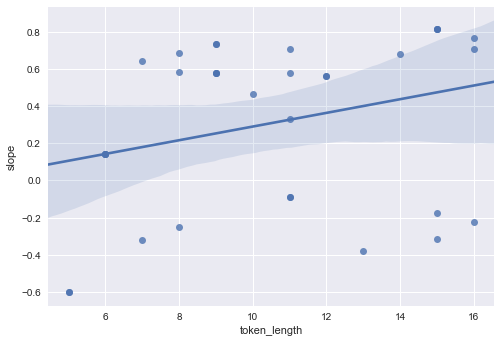

In [25]:
from scipy.stats import linregress
bdata = []
fname = 'depth_prop'
for sentence in Sentence.objects.experiment.kept:
    values = sentence.features(fname)
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(values)) / (len(values) - 1), values)
    bdata.append({'sentence_id': sentence.id, 'slope': slope, 'token_length': len(values)})
bdata = pd.DataFrame(bdata)

sb.regplot('token_length', 'slope', data=bdata)

## 4 Word trigger variation

### 4.0 Setup

Our plotting function

In [26]:
def plot_variation(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    quantiles = kwargs.get('quantiles', False)
    #feature_field = kwargs.get('feature_field', 'feature')
    x = data['parent_value']
    y = data['child_value']
    binning = kwargs.get('binning', 5)
    #h0 = data['h0' + rel]
    #h0n = data['h0n' + rel]
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(binning, 0, -1):
        try:
            x_bins, bins = cut(x, bin_count, labels=False,
                               retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    #h0s = np.zeros(bin_count)
    #h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        #h0s[i] = h0[indices].mean()
        #h0ns[i] = h0n[indices].mean()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))
    
    # Plot.
    nuphi = r'\nu_{\phi}'
    plt.plot(middles, values, '-', lw=2, color=color,
             label='${}$'.format(nuphi))
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    #plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
    #         label='${}^0$'.format(nuphi))
    #plt.plot(middles, h0ns, linestyle='-.',
    #         color=sb.desaturate(color, 0.2),
    #         label='${}^{{00}}$'.format(nuphi))
    plt.plot(middles, middles, linestyle='dotted',
             color=sb.desaturate(color, 0.2),
             label='$y = x$')
    lmin, lmax = middles[0], middles[-1]
    #h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    #if h0min < lmin:
    #    lmin = h0min - (lmax - h0min) / 10
    #elif h0max > lmax:
    #    lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

### 4.1 Features binned by global word distribution in the dataset

TODO: add H0s

#### 4.1.1 Binning by fixed width

##### 4.1.1.1 Absolute values

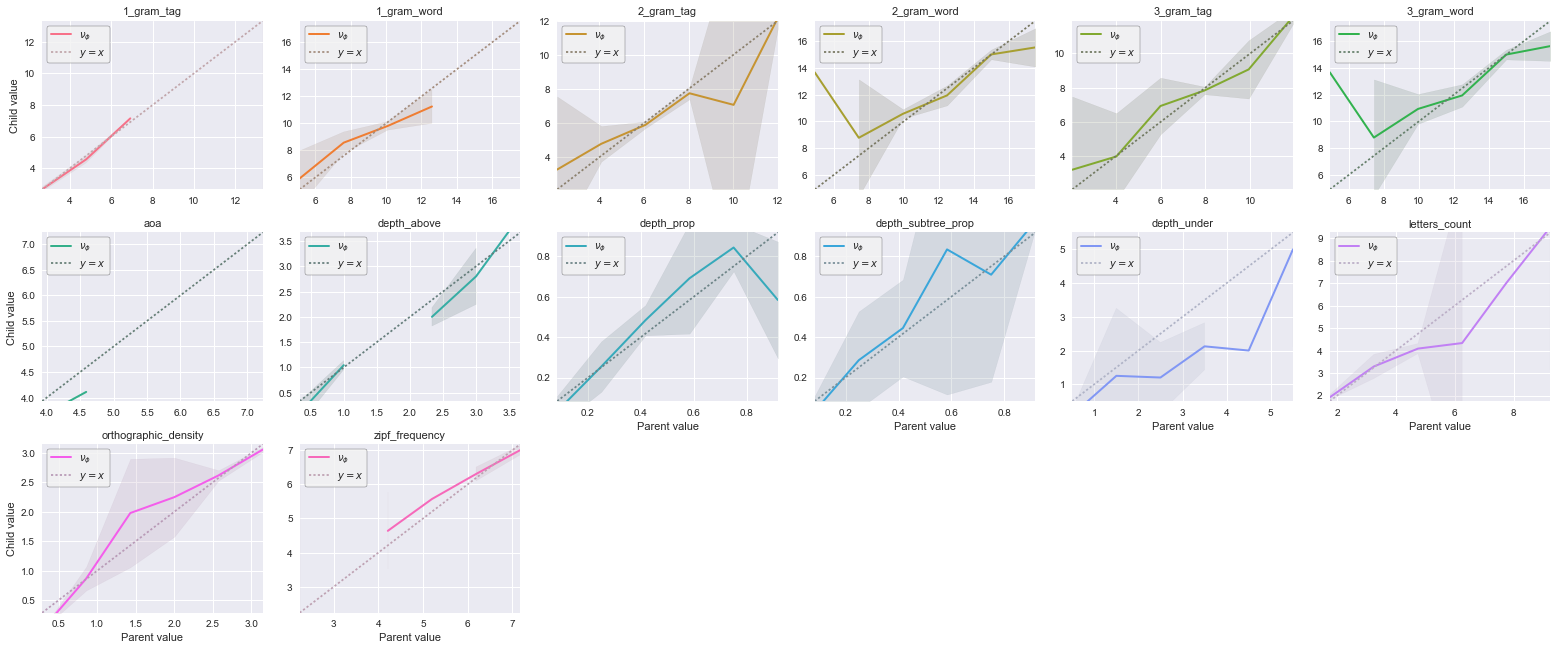

In [27]:
plot_grid(data, continuous_features, plot_variation,
          'Parent value', 'Child value', sharey=False,
          plot_kws={'binning': 6})

##### 4.1.1.2 Sentence-relative values

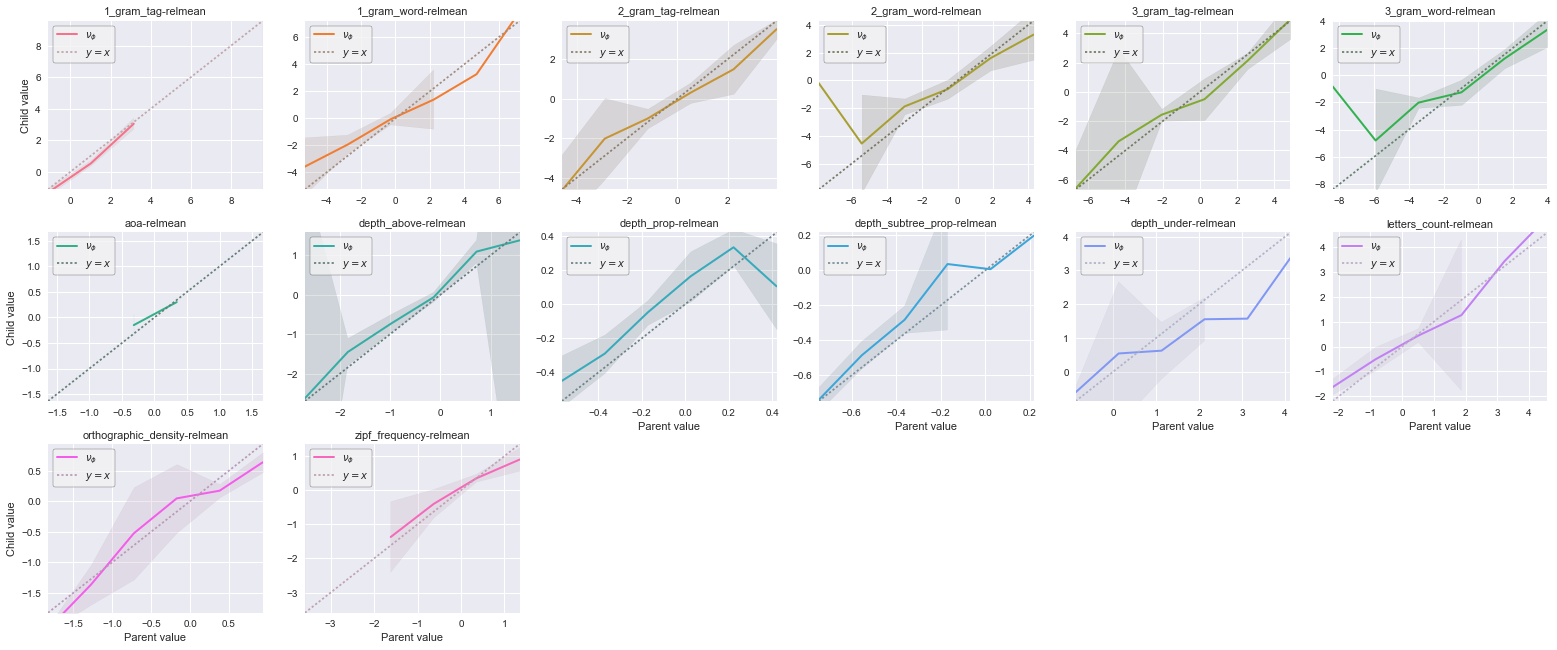

In [28]:
plot_grid(data, continuous_rel_features, plot_variation,
          'Parent value', 'Child value', sharey=False,
          plot_kws={'binning': 6})

#### 4.1.2 Binning by quantiles

##### 4.1.2.1 Absolute values

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.5, right=0.5
  'left=%s, right=%s') % (left, right))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.5, top=0.5
  'bottom=%s, top=%s') % (bottom, top))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=3.0, right=3.0
  'left=%s, right=%s') % (left, right))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:3179: UserWarn

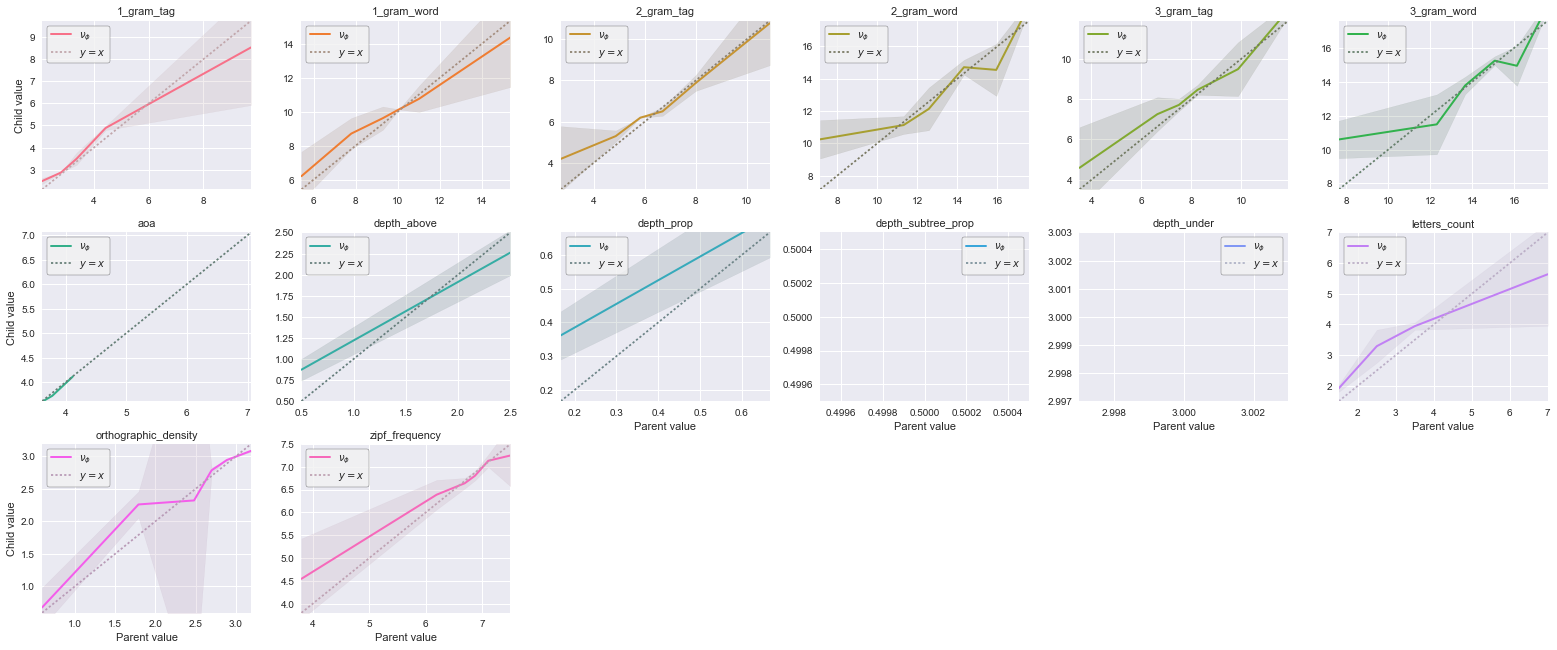

In [29]:
plot_grid(data, continuous_features, plot_variation,
          'Parent value', 'Child value', sharey=False,
          plot_kws={'quantiles': True, 'binning': 6})

##### 4.1.2.2 Sentence-relative values

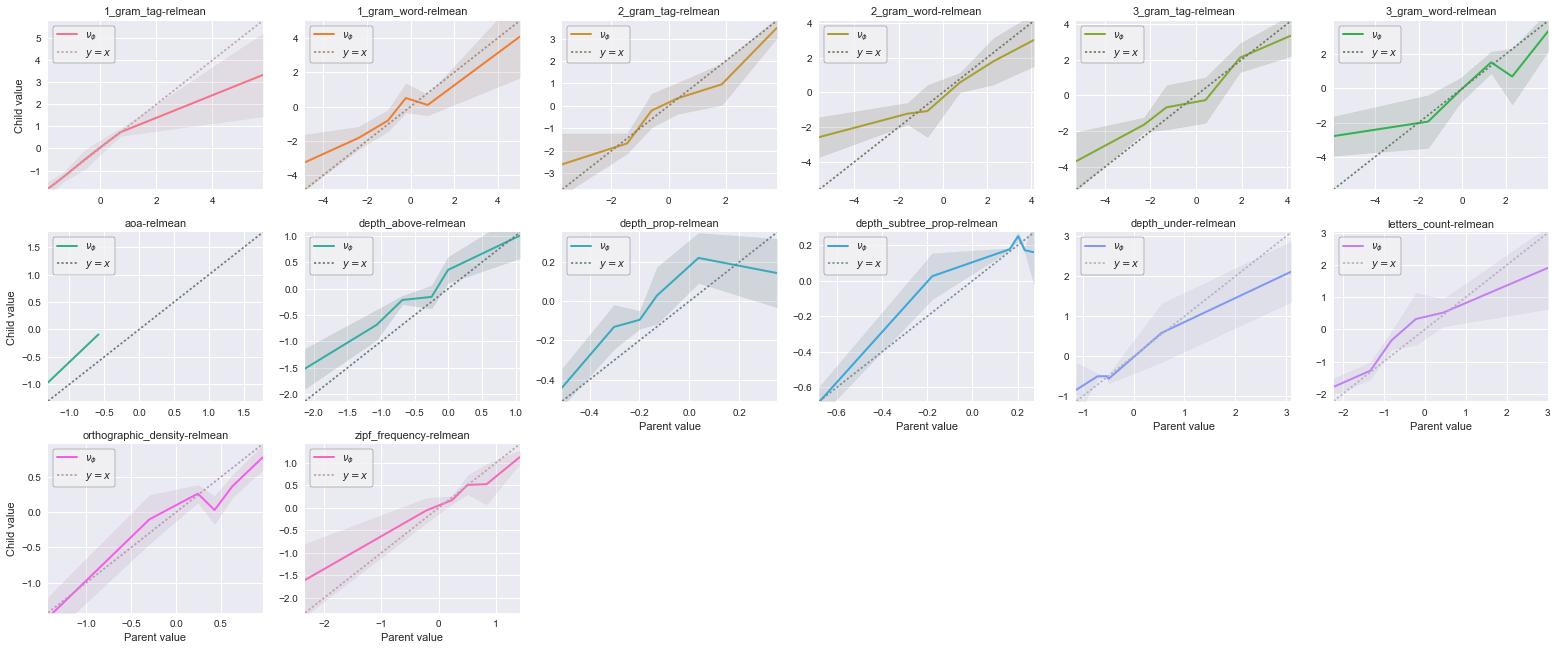

In [30]:
plot_grid(data, continuous_rel_features, plot_variation,
          'Parent value', 'Child value', sharey=False,
          plot_kws={'quantiles': True, 'binning': 6})